In [85]:
# reload magics
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [191]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import logging

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mc

import colorcet as cc

palette = cc.glasbey_hv

# set default colour for seaborn heatmaps
sns.set_theme(style = "white", rc={'figure.figsize':(8,8)}, palette='viridis')





## LOAD DATA

In [158]:
# load the data from the xlsx file
df = pd.read_excel('../lc-project-data/DATASET.xlsx')


In [159]:
# countries from the data dictionary

fn = "/Users/david/projects/lc-project-data/LCOPTIMIZE_DataDictionary_with codes-2024-04-08.xlsx"

countries = pd.read_excel(fn, sheet_name = "Countries")

# reset the index to be the country code
countries = countries.set_index("country_code")

countries

,country
country_code,
1,Algeria
2,Armenia
3,Australia
4,Austria
5,Bangladesh
...,...
95,Venezuela
96,Vietnam
97,Yugoslavia


In [160]:
# save countries as a dict for future reference

countries_dict = countries.to_dict(orient = "dict")

# save as json
import json

with open("./OUTPUT/countries.json", "w") as f:
    json.dump(countries_dict, f)



# FEATURE SETS

In [161]:
# get all column names
df_columns = df.columns

## DEMO + HX

In [162]:
# record id
RECORDS = ["record_id"]

# demographics etc
DEMOGRAPHICS = ["sex", "age", "home_location", "living_with", "number_of_persons_in_house"]

GEOGRAPHY = ["country"]
EMPLOYMENT = ["employed", "occupation", "hcp", "micro"]

# substances
SUBSTANCES = [col for col in df_columns if "substances___" in col]

# find all columns with hhx in the name
HEALTH    = ["global"]
HEALTH_HX = [col for col in df_columns if "hhx" in col]

# medications
MEDICATIONS = [col for col in df_columns if "medication" in col]

# PHX completeness
PHX_COMPLETE = ["phx_complete"]

# GAD
GAD = [col for col in df_columns if "_gad" in col]

# PROMIS
PROMIS = [col for col in df_columns if "promis29" in col]
PROMIS_COMPLETE = [col for col in df_columns if "promis_29_profile" in col]

# PHQ
PHQ = [col for col in df_columns if "phq" in col]
PHQ_COMPLETE = [col for col in df_columns if "patient_health_questionaire" in col]




In [163]:
# add up the health history information
HX = HEALTH_HX + MEDICATIONS + GAD + PROMIS + PHQ

# for each column in HX, check if there are values that are just spaces
for col in HX:
    # are any of the values just spaces?
    if df[col].apply(lambda x: isinstance(x, str) and x.isspace()).any():
        print(f"Column {col} has spaces")

        # remove the spaces and replace with blank
        # df[col] = df[col].apply(lambda x: np.nan if isinstance(x, str) else x)

# for each column in HX, check if there are values that are just spaces



<Axes: >

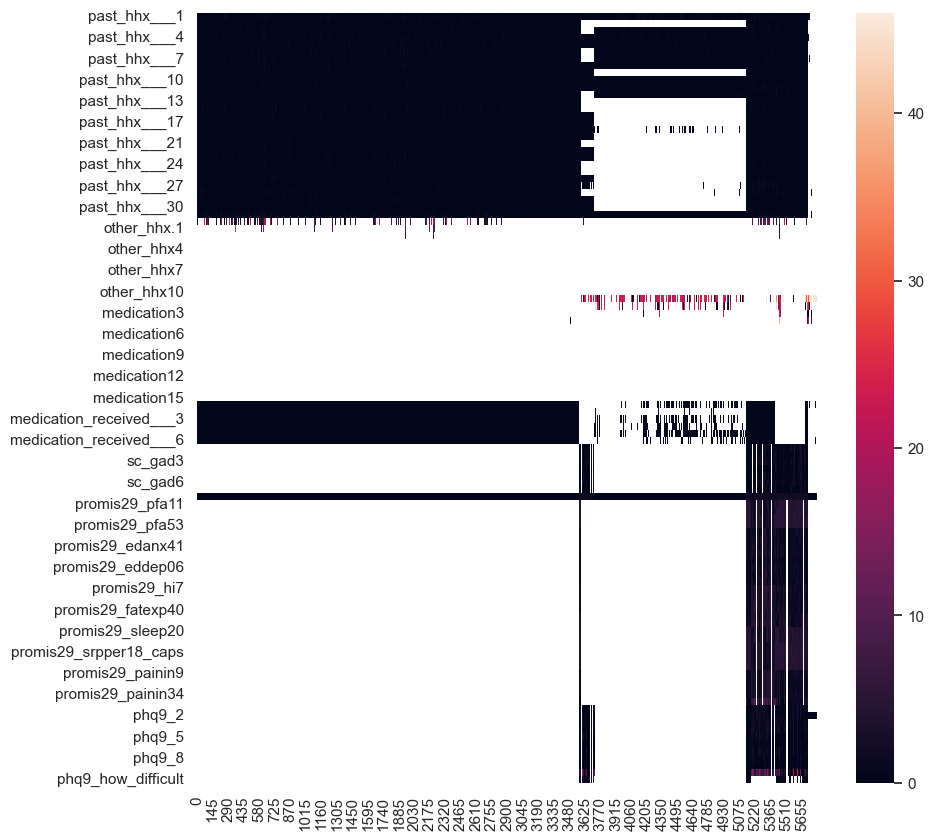

In [164]:
# plot it as a heatmap

import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 10))

sns.heatmap(df[HX].T, cbar=True, ax = ax)


In [165]:
# count countries
df["country"].value_counts()

country
16.0    2407
10.0     670
94.0      56
98.0      45
57.0      43
        ... 
2.0        1
65.0       1
17.0       1
76.0       1
38.0       1
Name: count, Length: 99, dtype: int64

In [166]:
# group by country and count the number of nulls per country
nulls_per_country = df.groupby("country").apply(lambda x: x.isnull().sum()).T.sum()

# look up the country code as the index


nulls_per_country = nulls_per_country.to_frame("nulls").join(countries)
nulls_per_country

,nulls,country
country,,
1.0,4484,Algeria
2.0,172,Armenia
3.0,445,Australia
4.0,195,Austria
5.0,1030,Bangladesh
...,...,...
95.0,999,Venezuela
96.0,907,Vietnam
97.0,193,Yugoslavia


## CLINICAL TESTS


In [167]:

s = "igg	wbc	neutrophil	neutrophil_count	lymphocyte	lymphocyte_count	monocyte	monocyte_count	eosinophil	eosinophil_count	basophil	basophil_count	platelets	haemoglobin	urea	creatinine	ntprobnp	bnp	sodium	potassium	crp	ldh	cpk	albumin		ast	alt	pct	troponinthigh	troponinihigh	troponint	troponini	aptt	inr	triglycerides	bilirubin	bilirubin_direct	glucose	fibrinogen	ferritin	il6	cd4	cd8	angiography	pocus	echocardiogram	echoresult	ekg	ekgresult	ekgcode	stented	cxr	cxrresult	cxrcode	cta	ctaresult	ctt	cttresult	cth	cthresult	imaging_results	imaging	spirometry	spirometryresult	metacholine	lung_function	lung_functionresult"
words = s.split()
words.sort()
CLINICAL_TESTS = words

# remove imaging_results from the list
CLINICAL_TESTS.remove("imaging_results")


CLIN_TESTS_COMPLETE = [col for col in df_columns if "clinical_tests_complete" in col]

In [168]:
df[CLINICAL_TESTS].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5797 entries, 0 to 5796
Data columns (total 65 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   albumin              1354 non-null   float64
 1   alt                  1718 non-null   float64
 2   angiography          7 non-null      float64
 3   aptt                 580 non-null    float64
 4   ast                  1055 non-null   float64
 5   basophil             568 non-null    float64
 6   basophil_count       840 non-null    float64
 7   bilirubin            1432 non-null   float64
 8   bilirubin_direct     703 non-null    float64
 9   bnp                  18 non-null     float64
 10  cd4                  2 non-null      float64
 11  cd8                  2 non-null      float64
 12  cpk                  151 non-null    float64
 13  creatinine           1469 non-null   float64
 14  crp                  1657 non-null   float64
 15  cta                  33 non-null     f

In [169]:
# # remove columns that have less than 200 non-null points
# TTT = [col for col in CLINICAL_TESTS if df[col].count() > 200]

# ttt = df[TTT].copy()
# ttt.info()

In [170]:
# sklearn median imputer

from sklearn.impute import SimpleImputer

imp = SimpleImputer(strategy='median')

ttt = df[CLINICAL_TESTS].copy()

ttt_imputed = pd.DataFrame(imp.fit_transform(ttt), columns = ttt.columns)

print(ttt_imputed.shape)

(5797, 65)


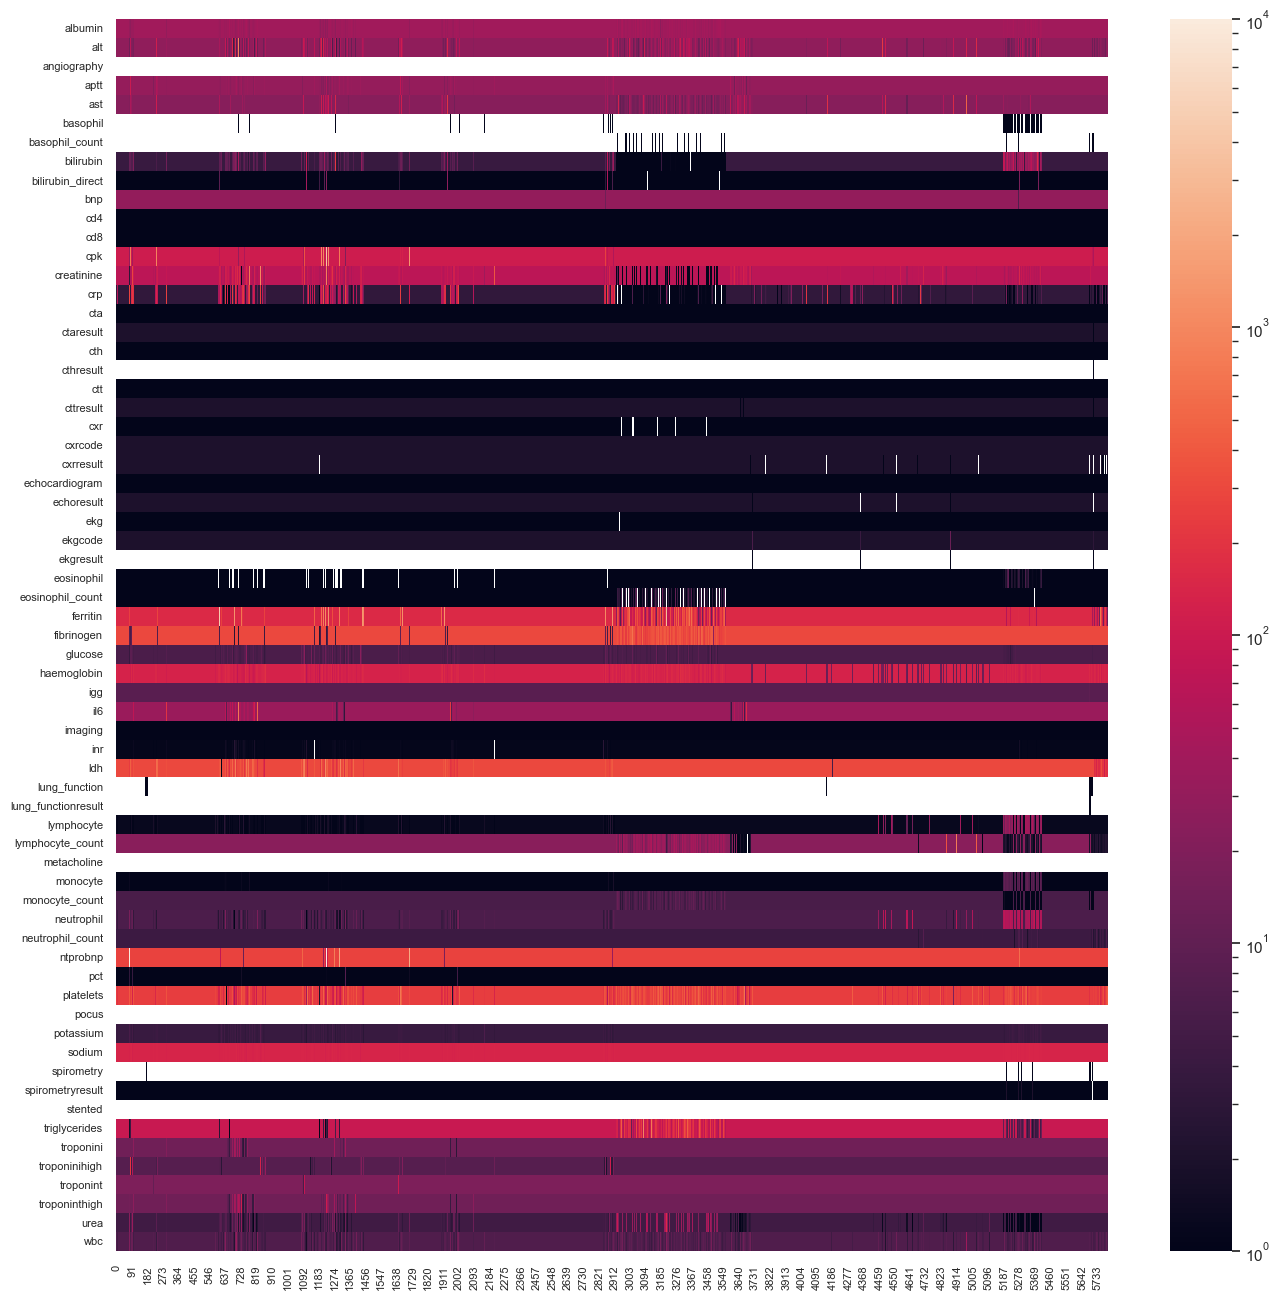

In [171]:
# # replace the nans with median values
# for col in TTT:
#     ttt[col] = ttt[col].fillna(ttt[col].median())

# plot the heatmap
fig, ax = plt.subplots(figsize=(16, 16))
norm = mc.LogNorm(vmin=1, vmax=10_000)
sns.heatmap(ttt_imputed.T, cbar=True, ax = ax, norm = norm)
# set text size smaller
plt.xticks(fontsize=8); plt.yticks(fontsize=8);


<Axes: >

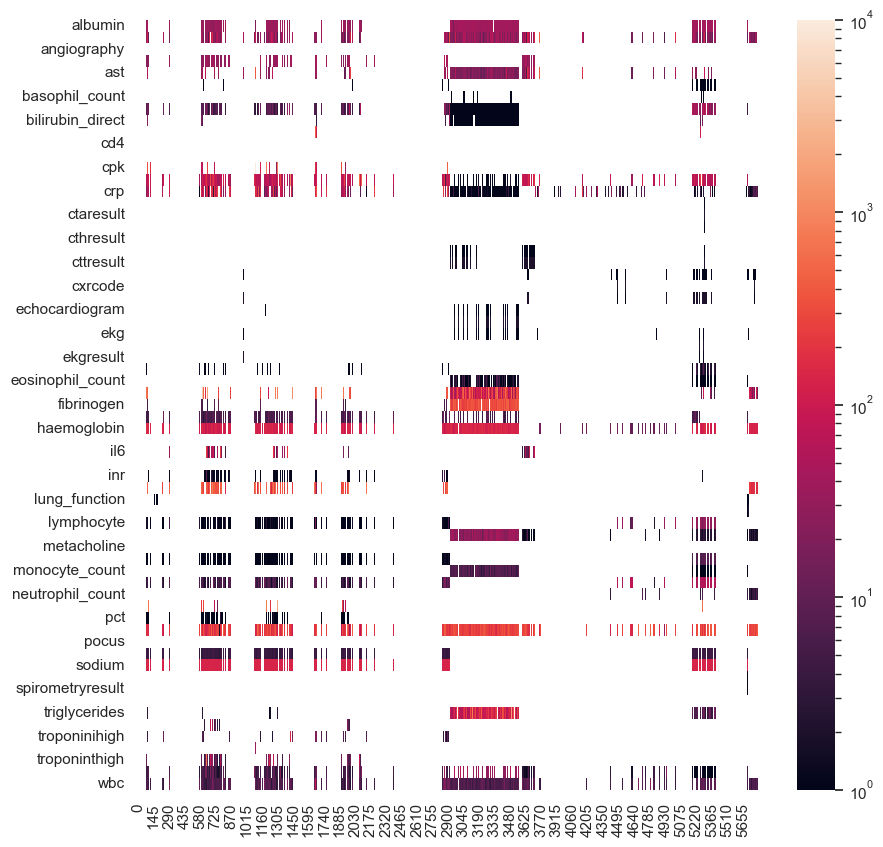

In [172]:
fig, ax = plt.subplots(figsize=(10, 10))
norm = mc.LogNorm(vmin=1, vmax=10_000)
sns.heatmap(df[CLINICAL_TESTS].T, cbar=True, ax = ax, norm = norm)

## VACCINES

In [173]:
VAX_STATUS = ["vaccinated"]


# given a list of substrings, find aall columns that contain the substrings
def find_columns(df_columns, substrings):
    return [col for col in df_columns if any(substring in col for substring in substrings)]

VAX = find_columns(df_columns, ["astra_zeneca", "pfizer", "moderna", "j_j", "sinoppharm", "sinovac", "sputnik", "other___"])

VAX_SIDE_EFFECTS = find_columns(df_columns, ["vac_sideeffect"])

<Axes: >

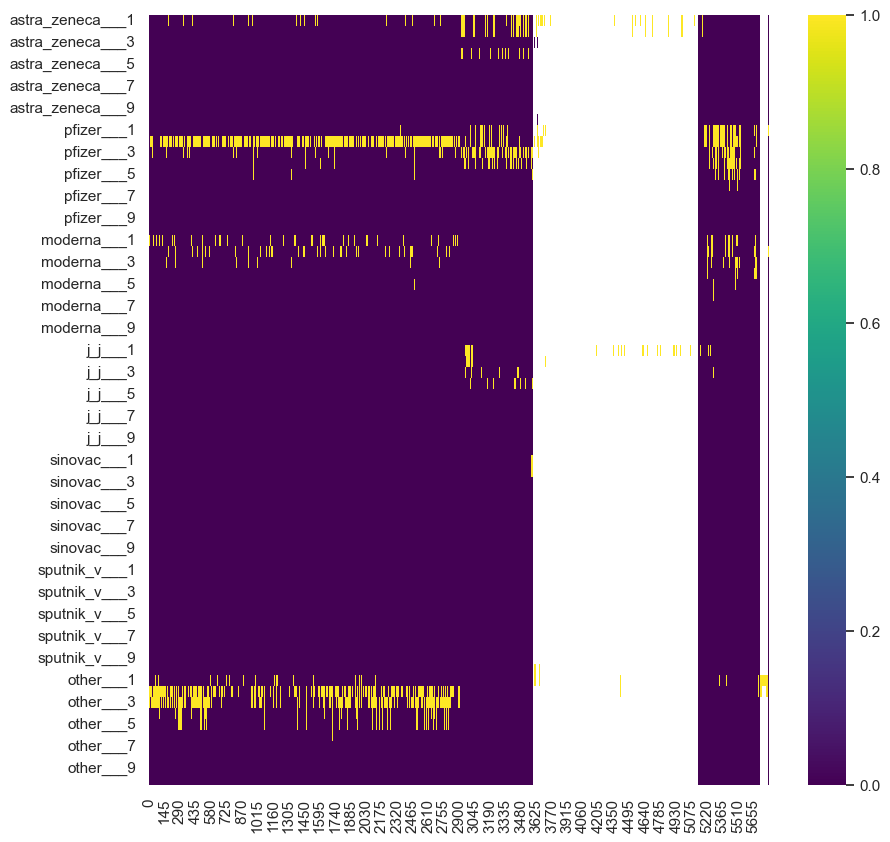

In [174]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 10))

sns.heatmap(df[VAX].T, cbar=True, ax = ax, cmap = "viridis")

## VIZ

## PARTICIPANT TYPES

In [175]:
df['participant_type'].value_counts()

participant_type
7     1778
6     1607
10    1147
13     493
5      327
4      242
8       84
11      43
3       38
2       31
1        7
Name: count, dtype: int64

In [176]:
# LC_positive types
pos_vals =  [2,4,6,8,9,12,13]
neg_vals = [1,5,7,10,]
hc_vals = [3,11, 14,15]


In [177]:
LC_pos = df.query('participant_type in @pos_vals')
LC_neg = df.query('participant_type in @neg_vals')
HC = df.query('participant_type in @hc_vals')

In [178]:
df['LC_STATUS'] = df['participant_type'].apply(lambda x: 'LC_POS' if x in pos_vals else 'LC_NEG' if x in neg_vals else 'HC')

<Axes: xlabel='LC_STATUS', ylabel='age'>

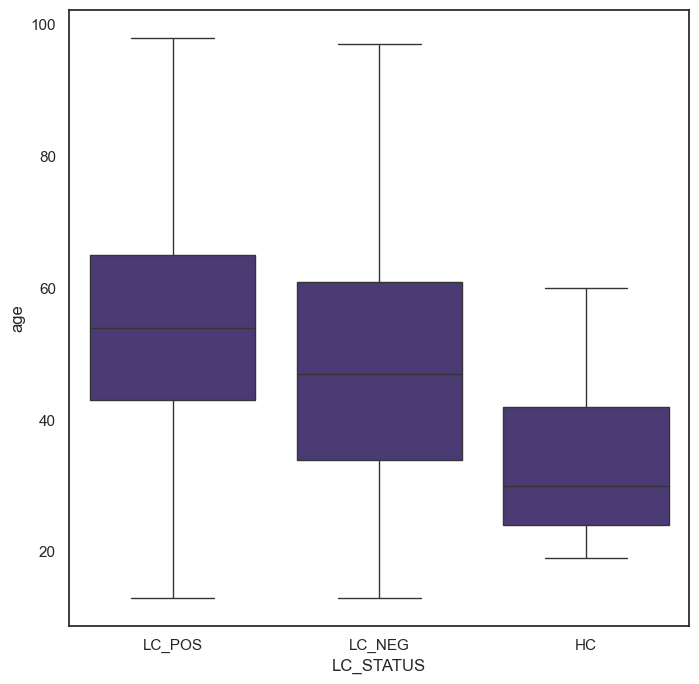

In [179]:
sns.boxplot(data=df, x='LC_STATUS', y='age')


In [192]:
LC_pos[CLINICAL_TESTS].shape

(2457, 65)

In [224]:
# clustering
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from hdbscan import HDBSCAN
from umap import UMAP

hdb_   = HDBSCAN(min_cluster_size=50, min_samples=5)
umap_  = UMAP(n_components=2, random_state=42)
scaler = MinMaxScaler().set_output(transform = "pandas")



In [225]:
X = scaler.fit_transform(ttt_imputed.loc[LC_pos.index])
X.shape

(2457, 65)

In [226]:
# drop the NAs
X = X.dropna()
X.shape

(2457, 65)

In [227]:
# umap
X_umap = umap_.fit_transform(X)

# cluster
hdb_.fit(X_umap)

/Users/david/mambaforge/envs/lm2/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


HDBSCAN(min_cluster_size=50, min_samples=5)

/var/folders/sb/yk61ysxx3bq0fh_vt074lv6w0000gn/T/ipykernel_84011/2350200302.py:5: UserWarning: The palette list has more values (256) than needed (9), which may not be intended.
  sns.scatterplot(x=X_umap[:,0], y=X_umap[:,1], hue=hdb_.labels_, s=10, palette = palette)


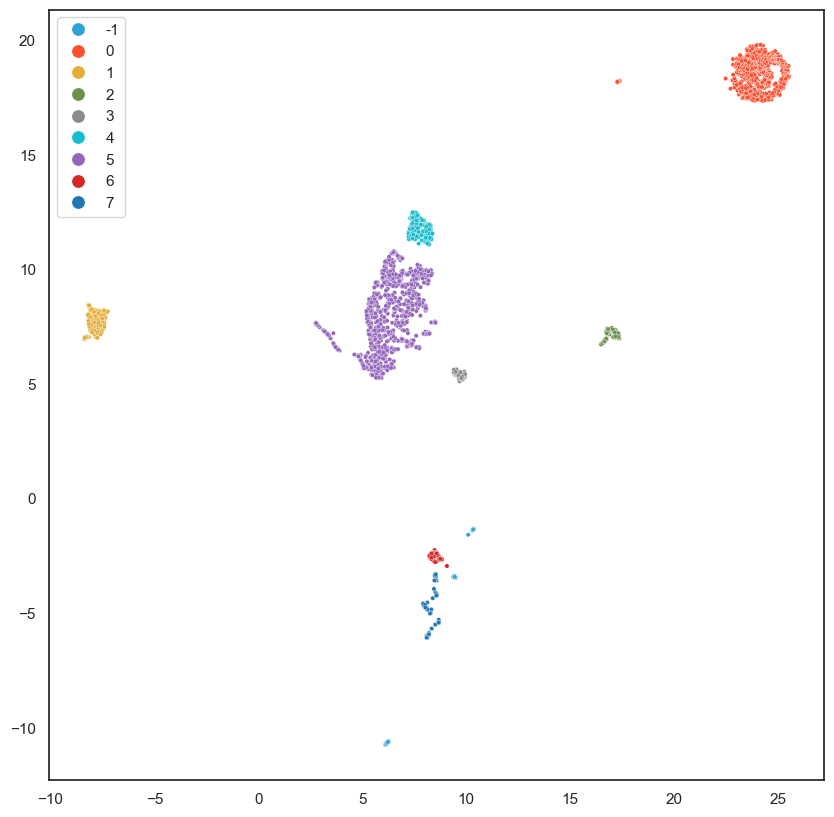

In [228]:

# plot the clusters

fig, ax = plt.subplots(figsize=(10, 10))

sns.scatterplot(x=X_umap[:,0], y=X_umap[:,1], hue=hdb_.labels_, s=10, palette = palette)

# make legend points larger
plt.legend(markerscale=3)

/Users/david/mambaforge/envs/lm2/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/var/folders/sb/yk61ysxx3bq0fh_vt074lv6w0000gn/T/ipykernel_84011/961173920.py:13: UserWarning: The palette list has more values (256) than needed (5), which may not be intended.
  sns.scatterplot(x=X_umap[:,0], y=X_umap[:,1], hue=hdb_.labels_, s=10, palette = palette)


<Axes: >

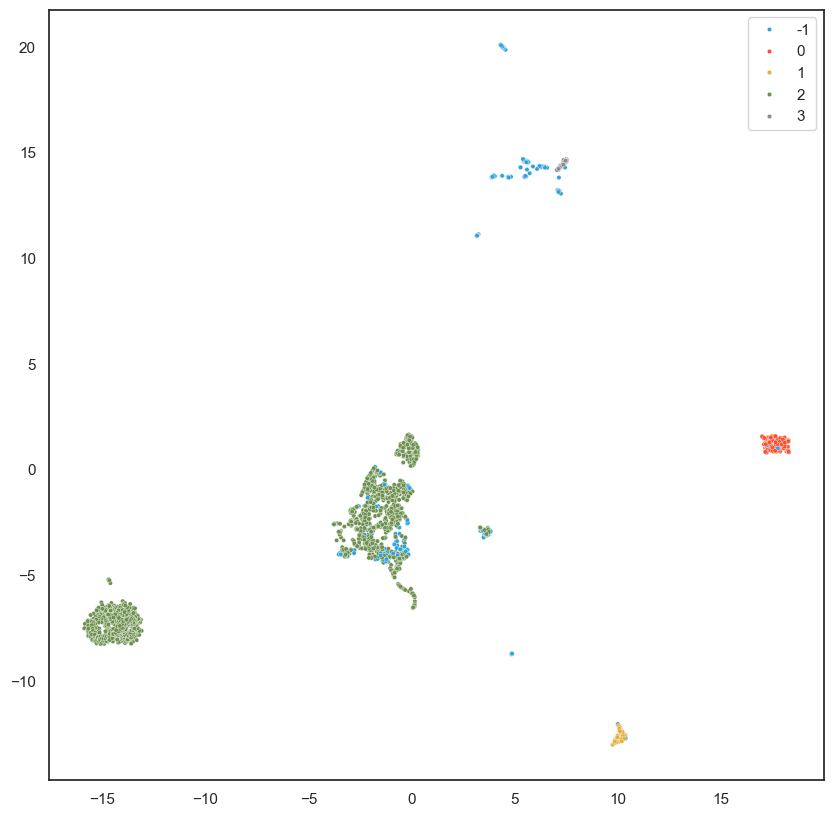

In [229]:
# another way - cluster first in high-dim space, then reduce to 2D

# cluster
hdb_.fit(X)

# umap
X_umap = umap_.fit_transform(X, y = hdb_.labels_)



/var/folders/sb/yk61ysxx3bq0fh_vt074lv6w0000gn/T/ipykernel_84011/671886348.py:5: UserWarning: The palette list has more values (256) than needed (5), which may not be intended.
  sns.scatterplot(x=X_umap[:,0], y=X_umap[:,1], hue=hdb_.labels_, s=50, palette = palette)


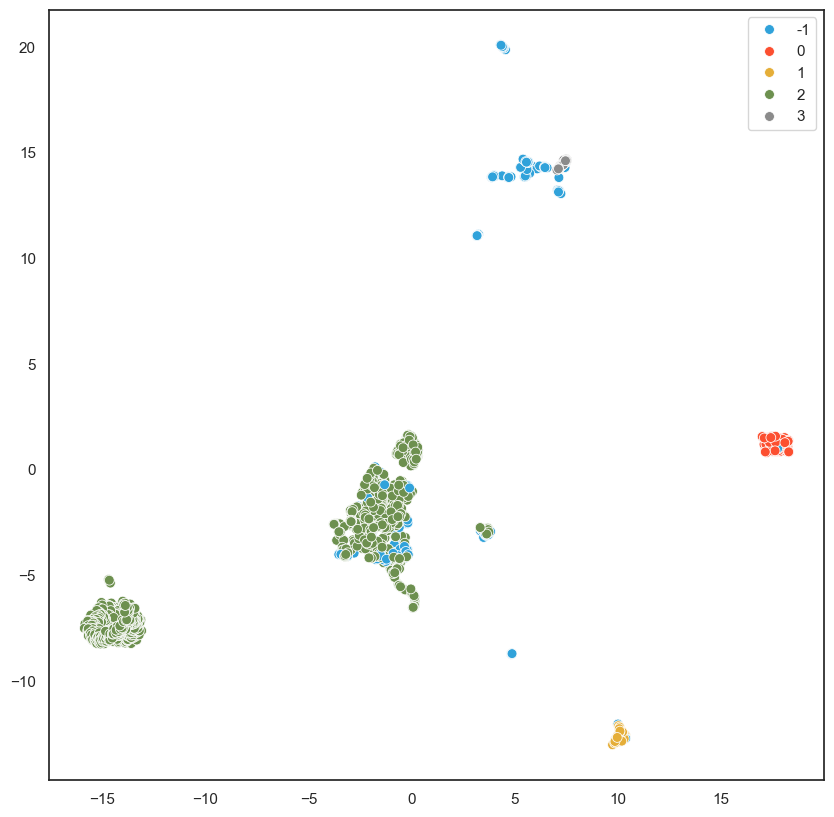

In [237]:

# plot the clusters

fig, ax = plt.subplots(figsize=(10, 10))

sns.scatterplot(x=X_umap[:,0], y=X_umap[:,1], hue=hdb_.labels_, s=50, palette = palette)
# make marker size larger
plt.legend(markerscale=1)

## EXAMINE THE MEANS

In [230]:
# make a dataferame using the mapped coordinates, cluster labels, and index from the original dataframe
df_umap = pd.DataFrame(X_umap, columns = ["x", "y"], index = X.index)
df_umap["cluster"] = hdb_.labels_

# add the cluster labels to the original dataframe
# df["cluster"] = hdb_.labels_

In [231]:
# save the cluster labels to the original dataframe
X["cluster"] = hdb_.labels_

# get the means by cluster
X.groupby("cluster").mean()



,albumin,alt,angiography,aptt,ast,basophil,basophil_count,bilirubin,bilirubin_direct,bnp,...,spirometry,spirometryresult,stented,triglycerides,troponini,troponinihigh,troponint,troponinthigh,urea,wbc
cluster,,,,,,,,,,,,,,,,,,,,,
-1,0.062713,0.037866,0.0,0.084314,0.066828,0.016534,0.013889,0.015550,0.017598,0.081720,...,0.098765,0.506173,0.0,0.066359,0.122885,0.006436,0.157109,0.025447,0.058880,0.228058
0,0.064442,0.027253,0.0,0.077950,0.046827,0.270470,0.004573,0.068994,0.033283,0.076160,...,0.000000,0.500000,0.0,0.012672,0.101852,0.001490,0.150538,0.016717,0.006659,0.205456
1,0.060214,0.034719,0.0,0.077950,0.043656,0.000000,0.500000,0.000804,0.002135,0.075163,...,0.000000,0.500000,0.0,0.089651,0.101852,0.001490,0.150538,0.016717,0.092178,0.170856
2,0.059320,0.027117,0.0,0.077918,0.044313,0.000583,0.000000,0.005999,0.002181,0.075124,...,0.000000,0.500000,0.0,0.067471,0.101515,0.001539,0.150210,0.016724,0.043610,0.195154
3,0.059432,0.029759,0.0,0.077950,0.047071,0.000000,0.000000,0.005876,0.001887,0.075163,...,0.000000,0.500000,0.0,0.059372,0.101852,0.001490,0.150538,0.016717,0.026748,0.163460


<Axes: xlabel='cluster', ylabel='crp'>

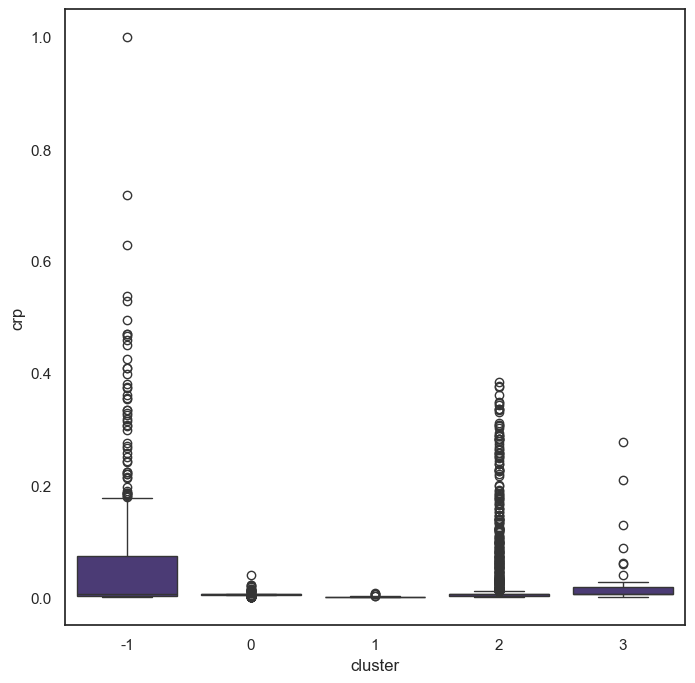

In [232]:
sns.boxplot(data=X, x="cluster", y="crp")

In [233]:
# how many columns in X?
X.shape

(2457, 66)

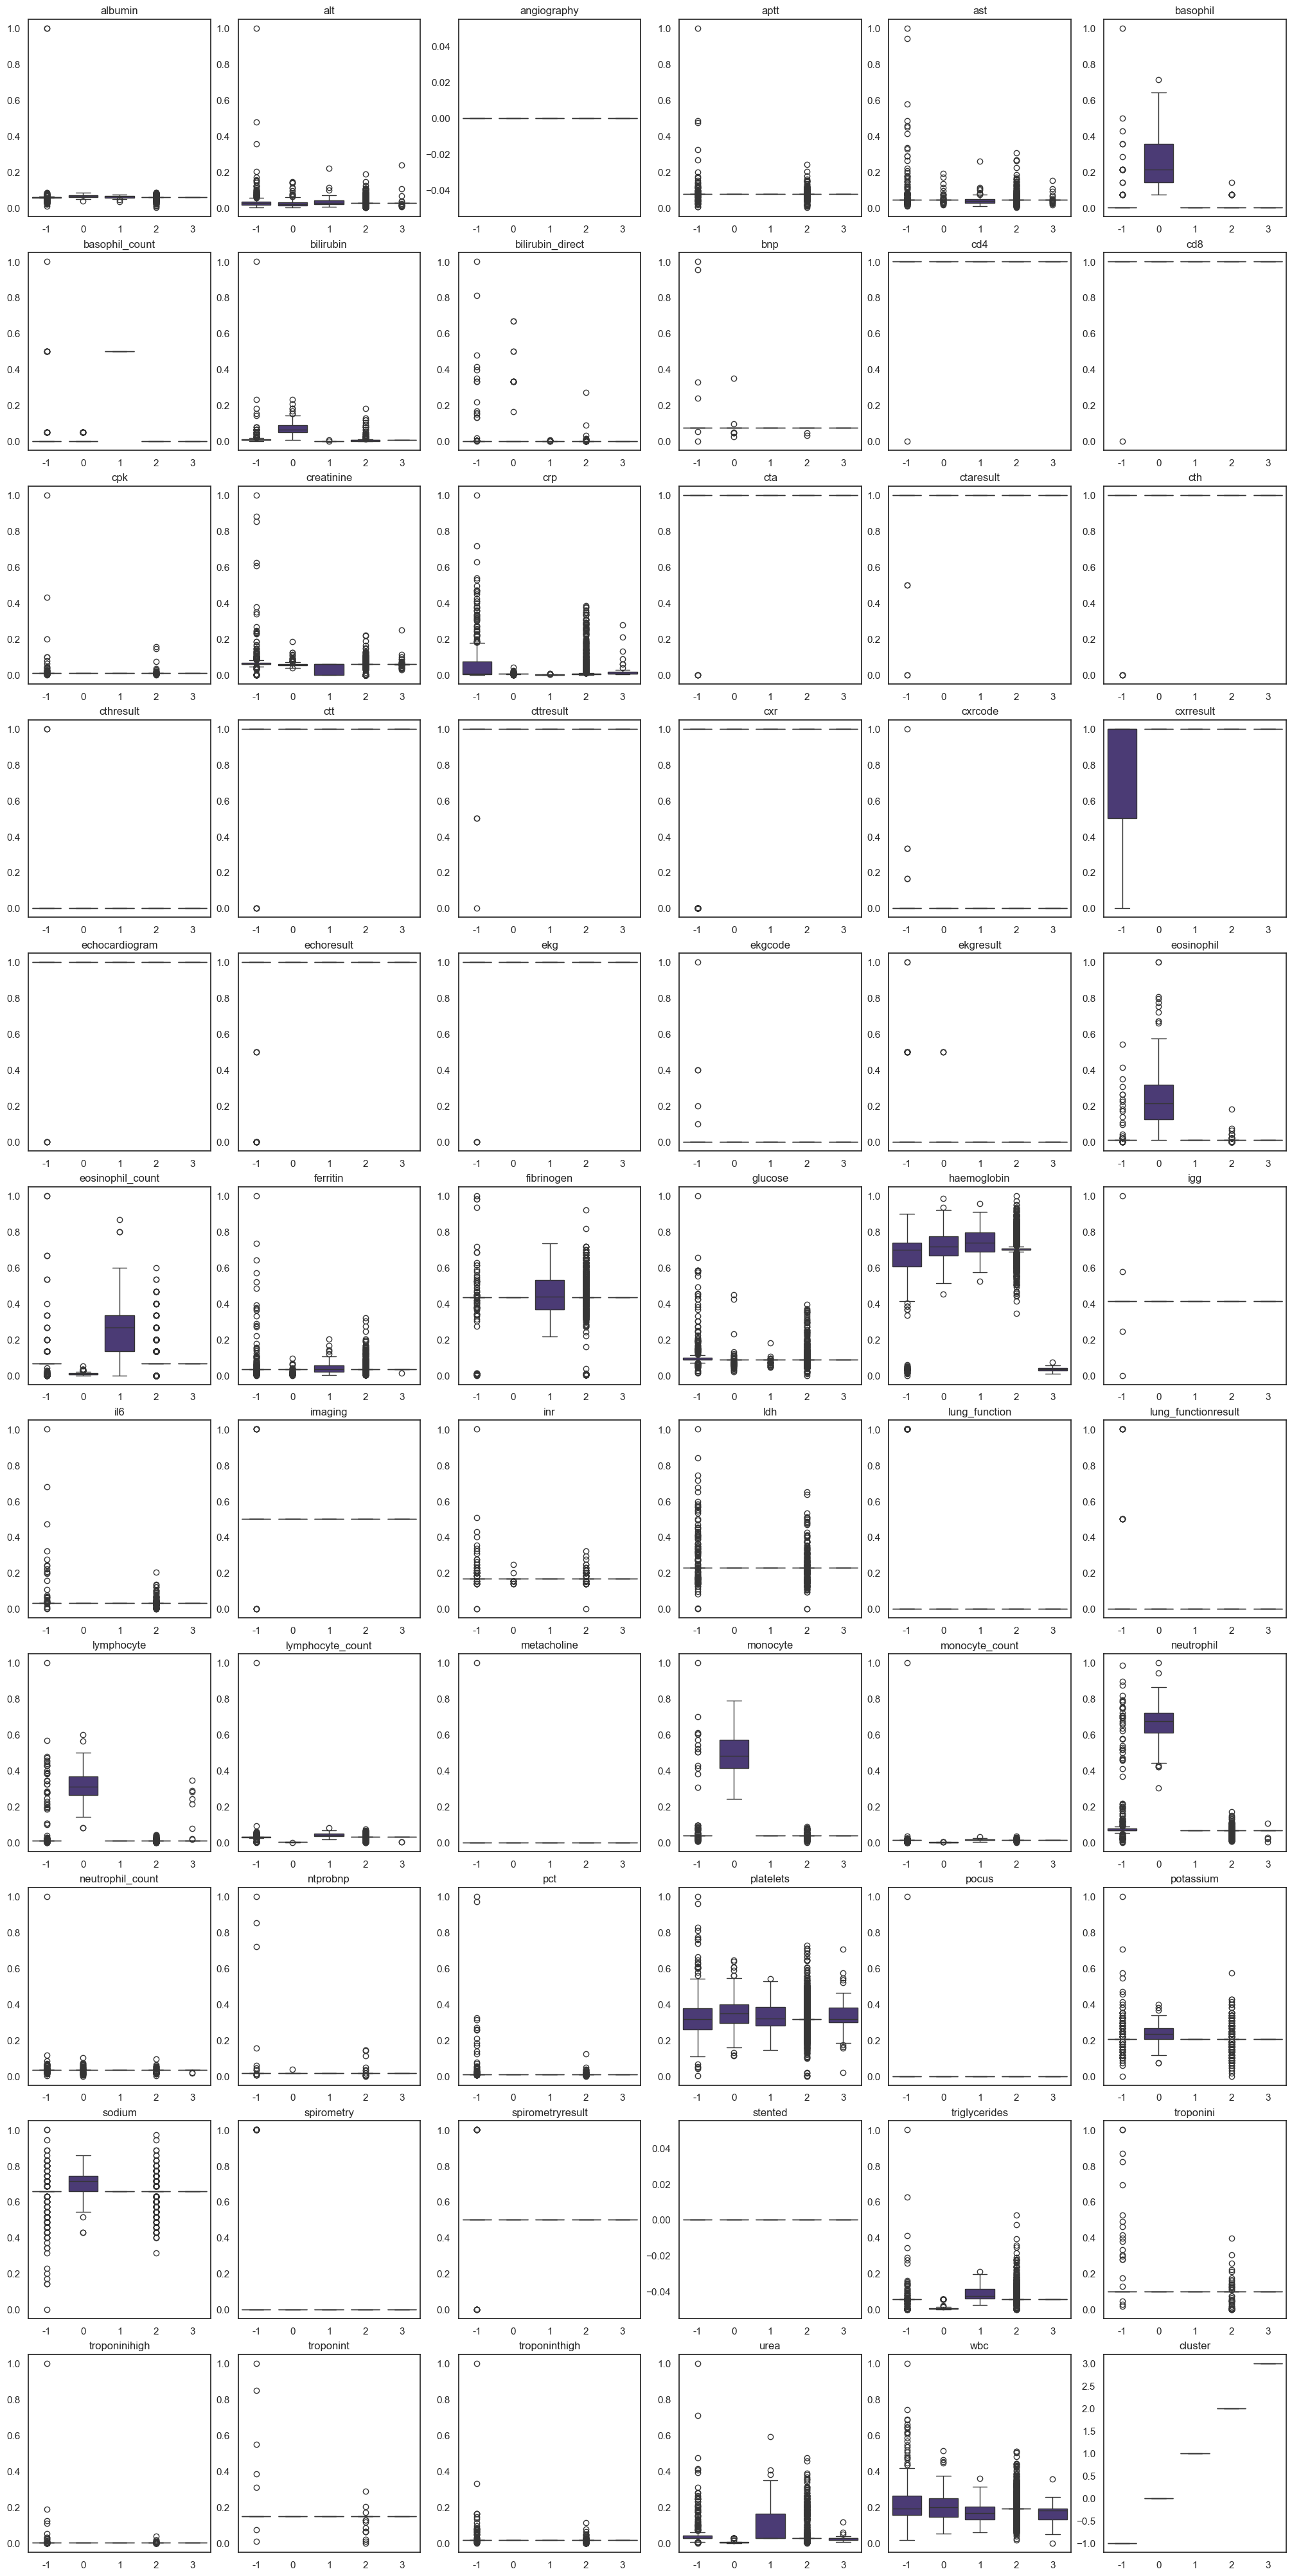

In [234]:
# make an array of plots for each column in X
fig, axs = plt.subplots(11, 6, figsize=(20, 40), layout = "constrained")

# flatten the axes into a list
axs = axs.flatten()


for i, col in enumerate(X.columns):
    sns.boxplot(data=X, x="cluster", y=col, ax = axs[i])
    # sns.boxplot(data=X, x="cluster", y=col, ax = axs[i//5, i%5])

    # set the title as the column name
    axs[i].set_title(col)
    # axs[i//5, i%5].set_title(col)

    # turn off the y axis label
    axs[i].set_ylabel("")
    axs[i].set_xlabel("")
    

# # plot the clusters
# fig, ax = plt.subplots(figsize=(10, 10))

# sns.scatterplot(x=X_umap[:,0], y=X_umap[:,1], hue=hdb_.labels_, s=10, palette = palette)